# 문제1
### 데이터 정규화를 위한 Mean과 Std 값 찾기


- import 단
    - BASE_PATH : link_dl 위치 확인

In [1]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn

from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

BASE_PATH = str(Path(os.getcwd()).resolve().parent.parent)  # BASE_PATH: /.../link_dl
print(BASE_PATH)

import sys

sys.path.append(BASE_PATH)

from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows

/home/kroad/jcw/link_dl


- mean과 std 계산 함수

In [2]:
def calculate_mean_std(data_loader):
    mean_sum = 0.0
    squared_mean_sum = 0.0
    total_samples = 0

    for images, _ in data_loader:
        batch_samples = images.size(0)  # 배치 크기
        total_samples += batch_samples

        # (B, C, H, W) 형태에서 (B, C, H*W)로 펼치기
        images = images.view(batch_samples, images.size(1), -1)

        # 각 배치별 평균과 제곱평균을 누적
        mean_sum += images.mean([0, 2]) * batch_samples
        squared_mean_sum += (images**2).mean([0, 2]) * batch_samples

    # 전체 평균 및 표준편차 계산
    mean = mean_sum / total_samples
    std = (squared_mean_sum / total_samples - mean**2).sqrt()

    print("\n")
    print("mean:", mean)
    print("std:", std)

    return mean, std


- 학습용 데이터 로드

In [3]:
def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

    num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    print("학습용 데이터셋의 평균 및 표준편차")
    cal_mean , cal_std = calculate_mean_std(train_data_loader)

    #정규화 함수
    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=cal_mean, std=cal_std),
    )

    # # 이미지 크기 조정을 위한 transform 수정 -- resnet gray_scale 변환
    # mnist_transforms = nn.Sequential(
    #     transforms.Resize(224),  # ResNet 입력 크기
    #     transforms.ConvertImageDtype(torch.float),
    #     transforms.Normalize(mean=[0.485], std=[0.229])  # 단일 채널용 정규화
    # )

    return train_data_loader, validation_data_loader, f_mnist_transforms

- 테스트용 데이터 로드

In [4]:
def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    print("테스트용 데이터셋의 평균 및 표준편차")
    cal_mean , cal_std = calculate_mean_std(test_data_loader)

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=cal_mean, std=cal_std),
    )

    # # 이미지 크기 조정을 위한 transform 수정 -- resnet gray_scale 변환
    # mnist_transforms = nn.Sequential(
    #     transforms.Resize(224),  # ResNet 입력 크기
    #     transforms.ConvertImageDtype(torch.float),
    #     transforms.Normalize(mean=[0.485], std=[0.229])  # 단일 채널용 정규화
    # )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

- 메인 함수

In [5]:
if __name__ == "__main__":
    config = {'batch_size': 2048, }
    wandb.init(mode="disabled", config=config)

    train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
    print()
    f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()


Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 12
학습용 데이터셋의 평균 및 표준편차


mean: tensor([0.2861])
std: tensor([0.3531])

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
테스트용 데이터셋의 평균 및 표준편차


mean: tensor([0.2868])
std: tensor([0.3524])


# 문제2

### CNN 학습 시키기

- cnn 모델 불러오기
    - code의 _10_cnn_architectures 가져옴
        - 입력값 : 배치 크기, 입력 채널 수(1- 흑백), 이미지 크기 : 28 x 28 (입력값 고정)

        - 출력값 : n_output (classify 하려는 클래스의 갯수와 동일)

In [6]:
from torch import optim
from datetime import datetime
from torchvision import models


BASE_PATH = str(Path(os.getcwd()).resolve().parent.parent)  # BASE_PATH: /.../link_dl
print(BASE_PATH)

CURRENT_FILE_PATH = str(Path(os.getcwd()).resolve())

CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

import sys

sys.path.append(BASE_PATH)

from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._08_fcn_best_practice.e_arg_parser import get_parser

/home/kroad/jcw/link_dl


- 제공된 cnn 모델로 94% 달성 실패
    - 'epochs': 1000,
    - 'batch_size': 32,
    - 'validation_intervals': 10,
    - 'learning_rate': 0.001,
    - 'early_stop_patience': 20,
    - 'early_stop_delta': 0.0001

-- 최저 loss : 0.25023

In [7]:
def get_cnn_model():
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()

      self.model = nn.Sequential(
        # B x 1 x 28 x 28 --> B x 6 x (28 - 5 + 1) x (28 - 5 + 1) = B x 6 x 24 x 24 
        nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=(5, 5), stride=(1, 1)),
        # B x 6 x 24 x 24 --> B x 6 x 12 x 12
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        # B x 6 x 12 x 12 --> B x 16 x (12 - 5 + 1) x (12 - 5 + 1) = B x 16 x 8 x 8
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1)),
        # B x 16 x 8 x 8 --> B x 16 x 4 x 4
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        # B x 16 x 4 x 4 --> B x 256
        nn.Flatten(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_output), # output - classify 하려는 클래스의 갯수와 동일
      )

    def forward(self, x):
      x = self.model(x)
      return x

  # 1 * 28 * 28
  my_model = MyModel(in_channels=1, n_output=10)

  return my_model

-  ResNet 적용 (실패)
    - 첫 레이어 수정 (3채널 -> 1채널)

In [8]:
# from torchvision import models

# def get_resnet(n_output=10, pretrained=True):
#     base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    
#     # 입력 채널 수정 (1채널)
#     base_model.conv1 = nn.Conv2d(
#         in_channels=1,
#         out_channels=64,
#         kernel_size=(7, 7),
#         stride=(2, 2),
#         padding=(3, 3),
#         bias=False
#     )

#     num_ftrs = base_model.fc.in_features
#     base_model.fc = nn.Linear(num_ftrs, 10)
    
#     return base_model

- cnn train 함수

In [ ]:
def main():
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': 1000,
        'batch_size': 64,
        'validation_intervals': 30,
        'learning_rate': 0.01,
        'early_stop_patience': 3,
        'early_stop_delta': 0.001
    }

    project_name = "cnn_mnist"
    wandb.init(
        project=project_name,
        notes="MNIST experiment with CNN",
        tags=["cnn", "mnist"],
        name=f"[cnn]{run_time_str}",
        config=config
    )
    print()
    print(wandb.config)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    train_data_loader, validation_data_loader, mnist_transforms = get_fashion_mnist_data()
    model = get_cnn_model()
    model.to(device)
    wandb.watch(model)

    optimizer = optim.SGD(model.parameters(), lr=wandb.config.learning_rate)

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, mnist_transforms,
        run_time_str, wandb, device, "./checkpoints"
    )
    classification_trainer.train_loop()

    wandb.finish()


if __name__ == "__main__":
    main()


Epoch,▁█
Training accuracy (%),▁█
Training loss,█▁
Training speed (epochs/sec.),▁█
Validation accuracy (%),▁█
Validation loss,█▁
Epoch,10
Training accuracy (%),78.50364
Training loss,0.58316
Training speed (epochs/sec.),0.11236
Validation accuracy (%),79.18



{'epochs': 1000, 'batch_size': 32, 'validation_intervals': 10, 'learning_rate': 0.01, 'early_stop_patience': 3, 'early_stop_delta': 0.001}
Training on device cpu.
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 12
학습용 데이터셋의 평균 및 표준편차


mean: tensor([0.2861])
std: tensor([0.3530])
[Epoch   1] T_loss: 0.88547, T_accuracy: 68.7945 | V_loss: 0.57966, V_accuracy: 77.7600 | Early stopping is initialized! | T_time: 00:00:09, T_speed: 0.111
[Epoch  10] T_loss: 0.30766, T_accuracy: 88.7473 | V_loss: 0.30504, V_accuracy: 89.1400 | V_loss decreased (0.57966 --> 0.30504). Saving model... | T_time: 00:01:29, T_speed: 0.112
[Epoch  20] T_loss: 0.24690, T_accuracy: 90.8964 | V_loss: 0.28292, V_accuracy: 89.8200 | V_loss decreased (0.30504 --> 0.28292). Saving model... | T_time: 00:02:51, T_speed: 0.117


KeyboardInterrupt: 

# 문제 3 & 4

### 분류 예측 결과 확인하기

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
테스트용 데이터셋의 평균 및 표준편차


mean: tensor([0.2868])
std: tensor([0.3524])
MODEL FILE: /home/kroad/jcw/link_dl/_02_homeworks/homework_3/checkpoints/cnn_mnist_checkpoint_latest.pt


/home/kroad/jcw/link_dl/_01_code/_08_fcn_best_practice/d_tester.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.latest_file_p

TEST RESULTS: 89.520%

     LABEL: 9


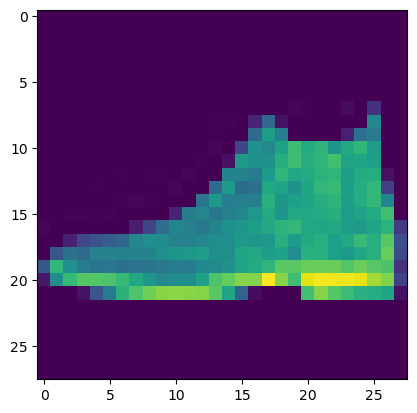

PREDICTION: 9


In [ ]:
import numpy as np
import torch
import os
from matplotlib import pyplot as plt
from pathlib import Path
from torchvision import datasets, transforms

BASE_PATH = str(Path(os.getcwd()).resolve().parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
CURRENT_FILE_PATH = str(Path(os.getcwd()).resolve())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

import sys
sys.path.append(BASE_PATH)

from _01_code._08_fcn_best_practice.d_tester import ClassificationTester


def get_fashion_mnist_test_data(batch_size=32):
    # FashionMNIST 테스트 데이터 로드 및 전처리
    mnist_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    mnist_test_dataset = datasets.FashionMNIST(
        root="./data", train=False, transform=mnist_transforms, download=True
    )

    test_data_loader = torch.utils.data.DataLoader(
        mnist_test_dataset, batch_size=batch_size, shuffle=False
    )

    return mnist_test_dataset, test_data_loader, mnist_transforms


def main():
    # 테스트 데이터 로드
    mnist_test_images, test_data_loader, mnist_transforms = get_fashion_mnist_test_data()

    # 모델 로드
    test_model = get_cnn_model()
    classification_tester = ClassificationTester(
        "cnn_mnist", test_model, test_data_loader, mnist_transforms, CHECKPOINT_FILE_PATH
    )

    # [문제 3] 테스트 데이터 정확도 확인
    print("Evaluating model on test data...")
    test_accuracy = classification_tester.test()

    # 정확도 기준 확인 및 출력
    print(f"\nTest Accuracy: {test_accuracy:.2f}%")
    if test_accuracy >= 93.0:
        print("✅ Test Accuracy meets the requirement (≥ 93%).")
    elif 90.0 <= test_accuracy < 93.0:
        print("⚠️ Test Accuracy is between 90% and 93% (partial points).")
    else:
        print("❌ Test Accuracy is below 90% (no points).")

    print("\n--- Sample Predictions ---")

    # [문제 4] 테스트 데이터에서 10개 샘플 추출 및 예측
    num_samples = 10
    samples = np.random.choice(len(mnist_test_images), num_samples, replace=False)

    for idx, sample_idx in enumerate(samples):
        img, label = mnist_test_images[sample_idx]
        print(f"\n[Sample {idx + 1}]")
        print("     True Label:", label)

        # 이미지 시각화
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(f"True Label: {label}")
        plt.axis("off")
        plt.show()

        # 모델 예측
        input_tensor = torch.tensor(np.array(img)).unsqueeze(dim=0).unsqueeze(dim=0)
        prediction = classification_tester.test_single(input_tensor)
        print("Predicted Label:", prediction)

        # 결과 비교 및 분석
        if label != prediction:
            print("❌ Prediction does not match the label. Investigate why.")
        else:
            print("✅ Prediction matches the label.")

    print("\n--- Testing Complete ---")


if __name__ == "__main__":
    main()


숙제 후기
- resnet으로 변경 시도하다가 하루가 없어져 버렸다. 시간 부족으로 결국 실패한 점이 아쉽다.
- 중간에 코드가 꼬여 이도 저도 못한 점이 아쉽다.
- gpt를 좀 더 잘 쓰도록 노력해야겠다.